<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: AmirHossein Jadidi
### Student ID: 402300461

# Import necessary libraries

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 174965012.83it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 59322083.17it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 56287165.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16522574.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [5]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

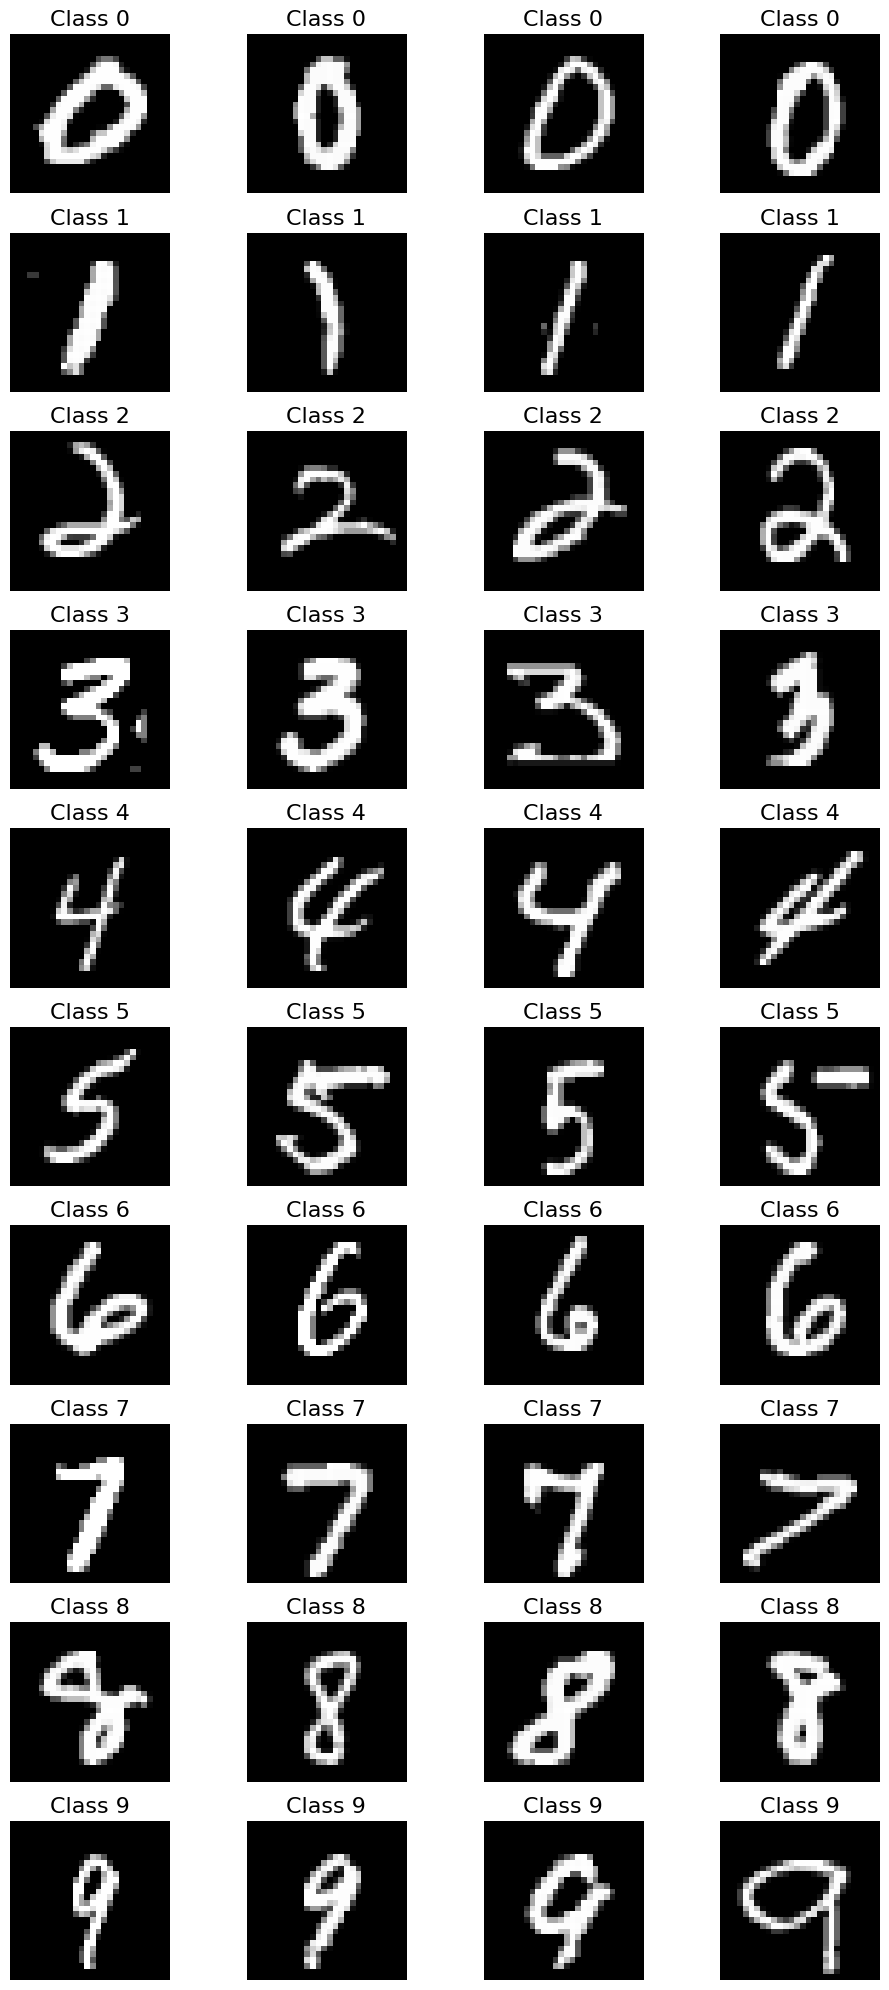

In [6]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

In [7]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Simple Decoder Architechture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Sigmoid activation for the reconstruction
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, input_dim)
        hidden = self.encoder(x)
        
        mu = self.fc_mu(hidden) # Latent space mean
        logvar = self.fc_logvar(hidden) # Latent space var
        
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

In [8]:
# Define VAE loss function
def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data.view(-1, input_dim), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL divergence distance loss
    total_loss = reconstruction_loss + kl_divergence
    return total_loss

def generate_and_show_sample_images_vae(model, num_samples=6):
    model.eval()
    with torch.no_grad():
        sample = torch.randn(num_samples, latent_dim)
#         if isinstance(model, CVAE_MLP):
#             num_classes = 10  # Number of classes (0 to 9)
#             y = torch.eye(num_classes).repeat(num_samples // num_classes, 1).to(device)
#             sample = torch.cat([sample, y], dim=1)
        sample = model.decoder(sample).view(num_samples, 1, 28, 28)
        sample = sample.squeeze().cpu()
        fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            axs[i].imshow(sample[i], cmap='gray')
            axs[i].axis('off')
        plt.show()


In [9]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=2e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data
            # Forward process
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            data = data.view(-1, input_dim)
            recon = recon.view(-1, input_dim)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
        
        generate_and_show_sample_images_vae(model)
        
        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/20], Loss: 191.35671175130207


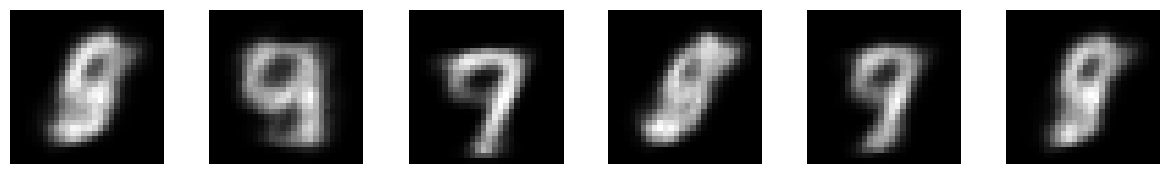


##################################################
VAE-MLP Epoch [2/20], Loss: 164.59917828776042


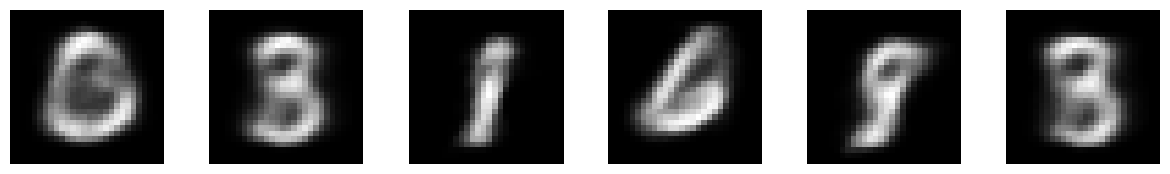


##################################################
VAE-MLP Epoch [3/20], Loss: 159.80688500976564


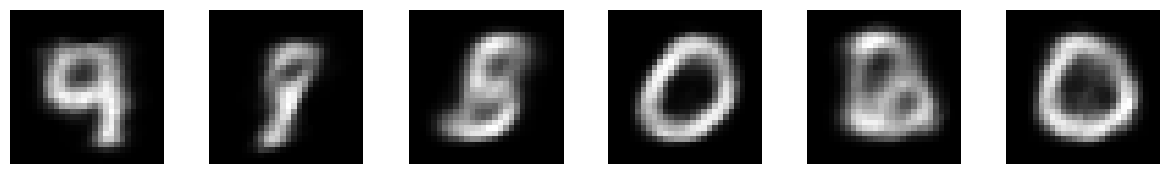


##################################################
VAE-MLP Epoch [4/20], Loss: 156.77270297851564


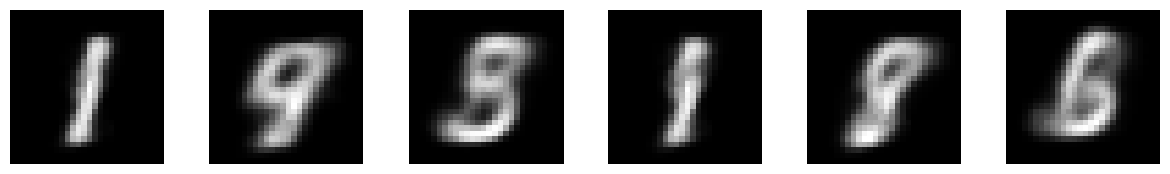


##################################################
VAE-MLP Epoch [5/20], Loss: 154.74017936197916


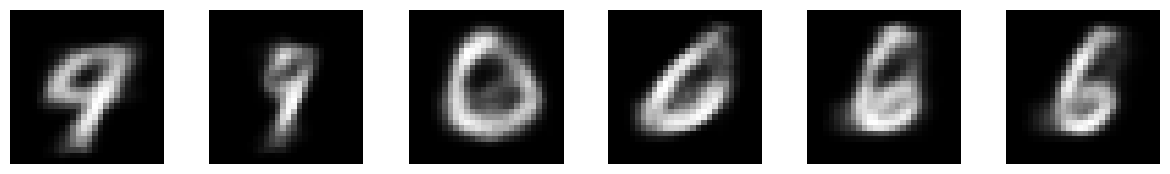


##################################################
VAE-MLP Epoch [6/20], Loss: 153.3719418782552


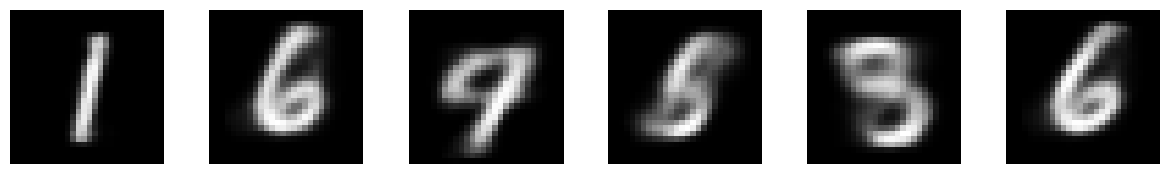


##################################################
VAE-MLP Epoch [7/20], Loss: 152.19798637695314


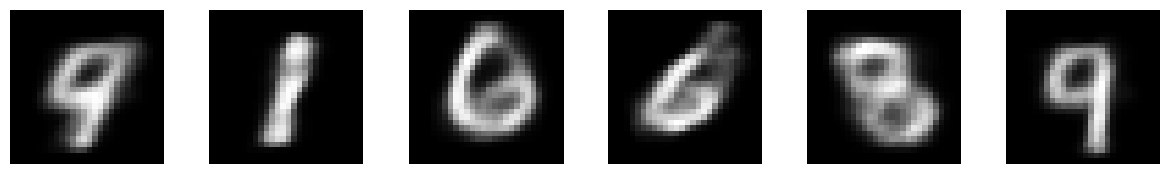


##################################################
VAE-MLP Epoch [8/20], Loss: 151.29056920572916


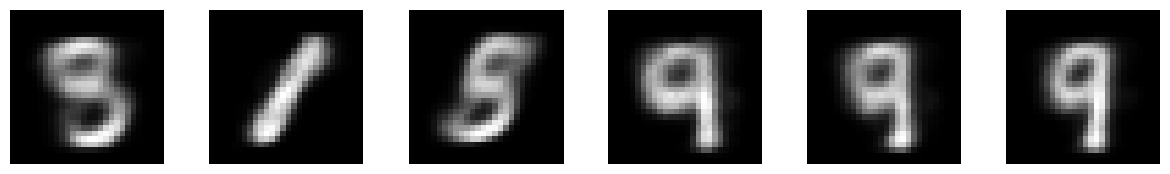


##################################################
VAE-MLP Epoch [9/20], Loss: 150.41171197916665


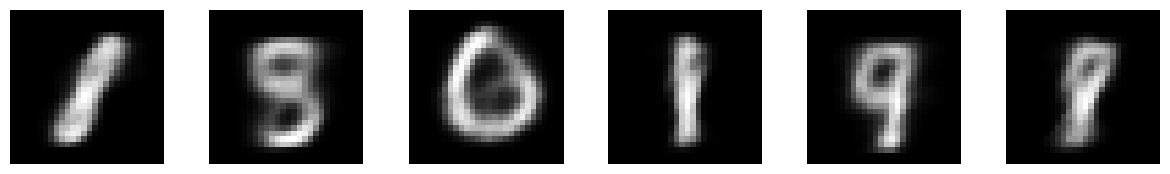


##################################################
VAE-MLP Epoch [10/20], Loss: 149.80746095377603


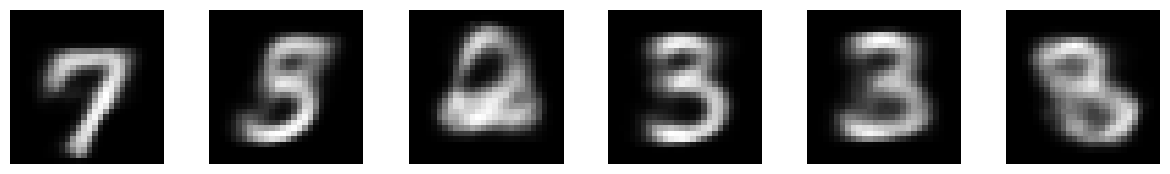


##################################################
VAE-MLP Epoch [11/20], Loss: 148.93936206054687


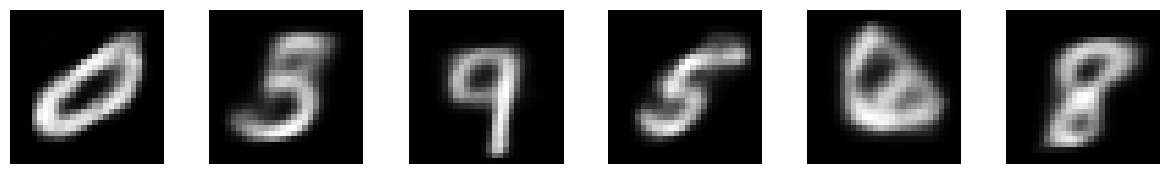


##################################################
VAE-MLP Epoch [12/20], Loss: 148.4232209798177


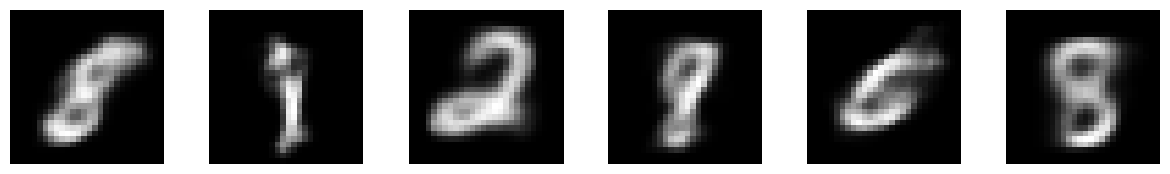


##################################################
VAE-MLP Epoch [13/20], Loss: 147.78400693359376


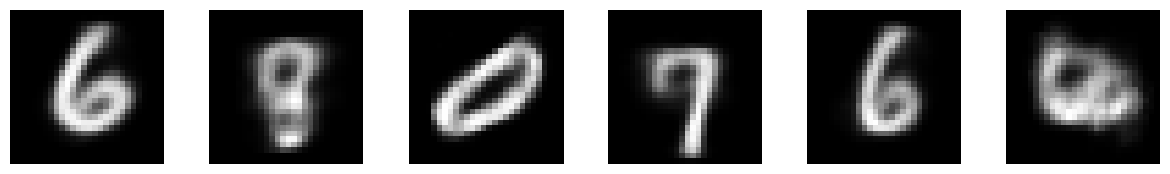


##################################################
VAE-MLP Epoch [14/20], Loss: 147.36671842447916


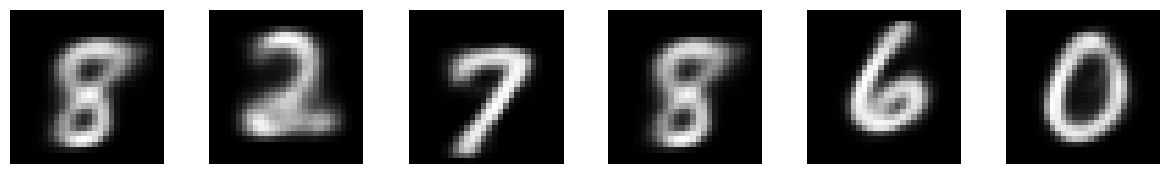


##################################################
VAE-MLP Epoch [15/20], Loss: 147.00180522460937


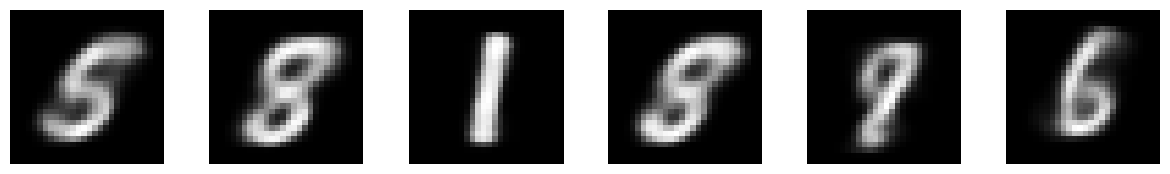


##################################################
VAE-MLP Epoch [16/20], Loss: 146.5348572265625


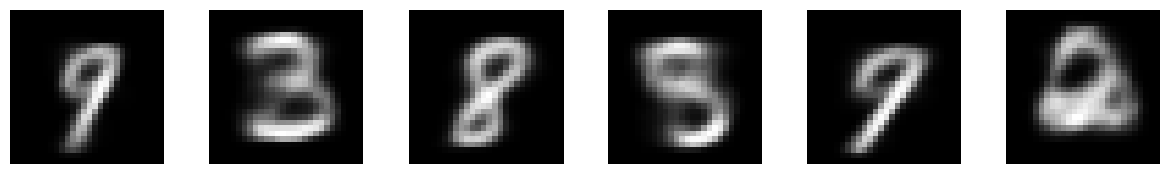


##################################################
VAE-MLP Epoch [17/20], Loss: 146.0634855794271


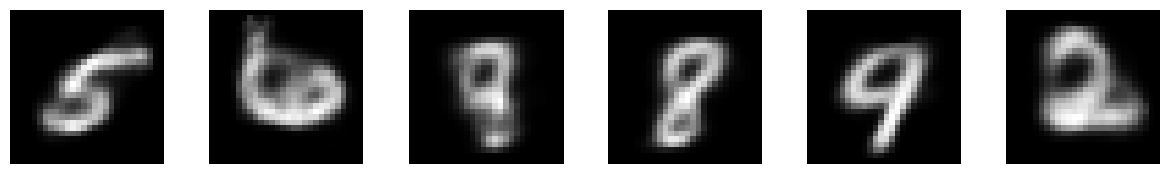


##################################################
VAE-MLP Epoch [18/20], Loss: 145.94072320963542


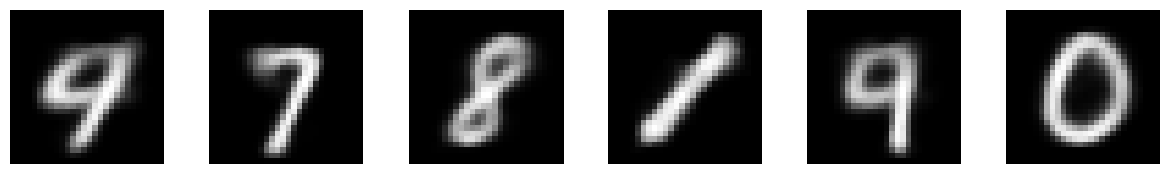


##################################################
VAE-MLP Epoch [19/20], Loss: 145.78280467122397


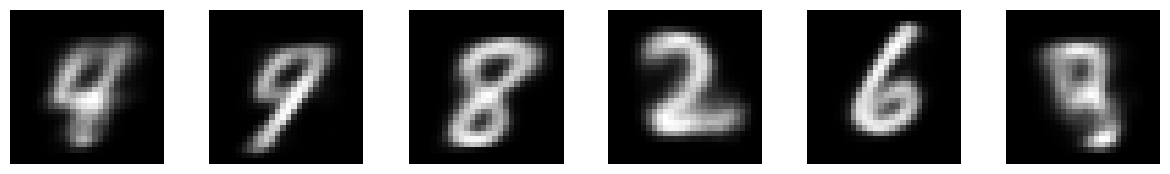


##################################################
VAE-MLP Epoch [20/20], Loss: 145.30622807617186


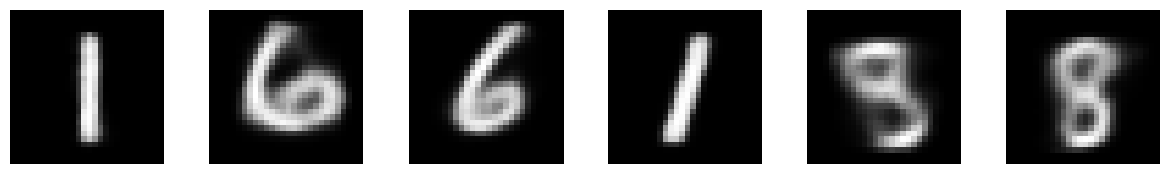

Best model saved as 'best_vae_mlp_model.pth'


In [10]:
# Train VAE-MLP
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [11]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # Simple Conditional Encoder Architechture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim), # we want to concatenate, so we use higher input dim for first layer
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # Simple Conditional Decoder Architechture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        x = torch.cat([x, y], dim=1) # As mentioned before, we will concatenate x and y before passing them to the encoder
        # Encoder
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        # Decoder
        decoded = torch.cat([z, y], dim=1)
        reconstructed = self.decoder(decoded)

        return reconstructed, mu, logvar, class_logits


In [12]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1, input_dim)

    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum') # Reconstruction loss, we have chosen BCE
    
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL distance divergence loss

    ce_loss = F.cross_entropy(class_logits, labels) # For cvae we need class loss, we have chosen CE loss

    # Todo: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence 
# + ce_loss

def generate_and_show_sample_images_cvae(model, num_samples=6, latent_dim=2, num_classes=10):
    model.eval()
    with torch.no_grad():
        # Generate random samples
        z = torch.randn(num_samples, latent_dim)
        # Generate random class labels
        y = F.one_hot(torch.randint(0, num_classes, (num_samples,), dtype=torch.long), num_classes)
        # Concatenate the random samples and class labels before passing them to the decoder
        sample = torch.cat([z, y.float()], dim=1)
        sample = model.decoder(sample).view(num_samples, 1, 28, 28)
        sample = sample.squeeze().cpu()

        # Plot the generated samples with labels
        plt.figure(figsize=(15, 2))
        for i in range(num_samples):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(sample[i], cmap='gray')
            plt.title(f'Label: {y[i].nonzero().item()}')
            plt.axis('off')

        plt.show()


In [13]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
        generate_and_show_sample_images_cvae(model)
#         # Show some sample images after each epoch
#         if (epoch + 1) % 1 == 0:
#             print("Sample Images:")
#             with torch.no_grad():
#                 num_classes = 10  # Number of classes (0 to 9)
#                 num_samples_per_class = 1  # One sample per class
#                 # Generate random samples
#                 z = torch.randn(num_classes * num_samples_per_class, latent_dim)
#                 # Generate one-hot encoded class labels
#                 y = F.one_hot(torch.arange(num_classes).repeat(num_samples_per_class), num_classes)
#                 # Concatenate the random samples and class labels before passing them to the decoder
#                 sample = torch.cat([z, y.float()], dim=1)
#                 sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
#                 sample = sample.squeeze().cpu()
#                 fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
#                 for i in range(num_classes):
#                     axs[i].imshow(sample[i], cmap='gray')
#                     axs[i].set_title(f"Class {i}", fontsize=16)
#                     axs[i].axis('off')
#                 plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/20], Loss: 197.12943188476564


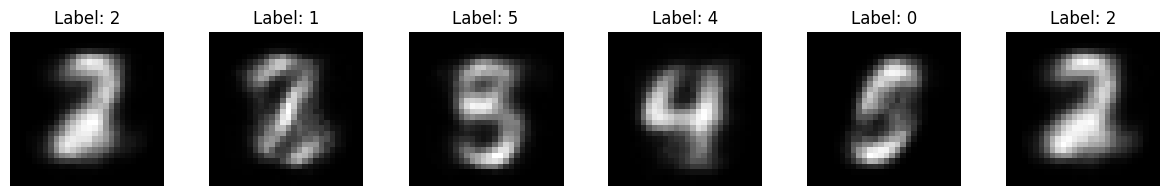


##################################################
CVAE-MLP Epoch [2/20], Loss: 149.56575960286457


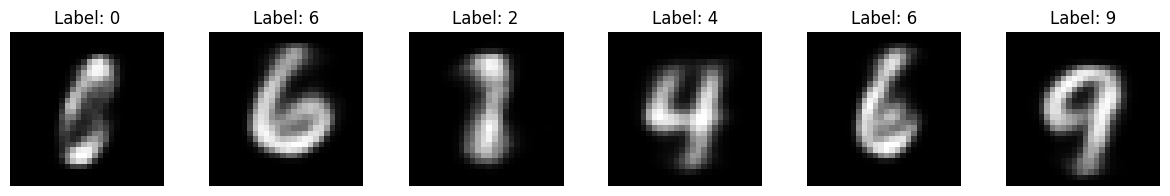


##################################################
CVAE-MLP Epoch [3/20], Loss: 142.86715550130208


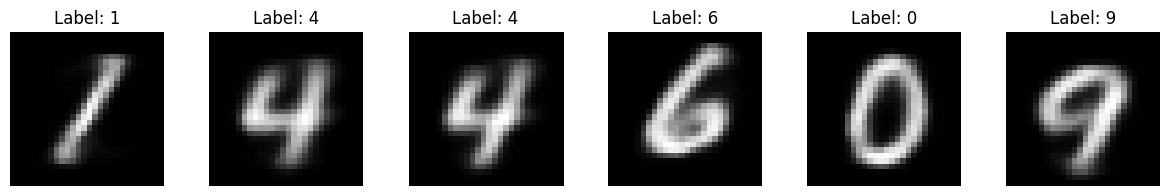


##################################################
CVAE-MLP Epoch [4/20], Loss: 139.71675592447917


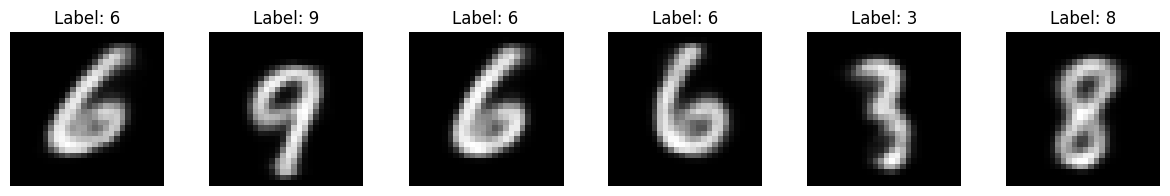


##################################################
CVAE-MLP Epoch [5/20], Loss: 137.85031552734375


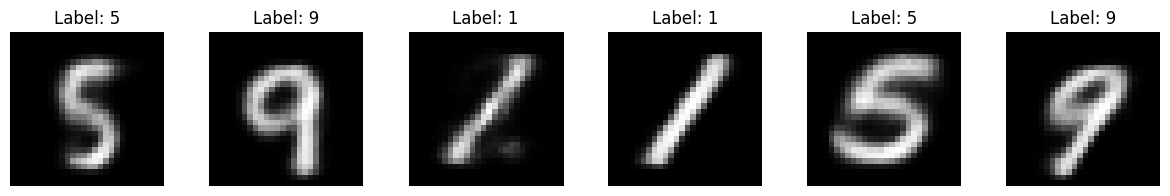


##################################################
CVAE-MLP Epoch [6/20], Loss: 136.46429503580728


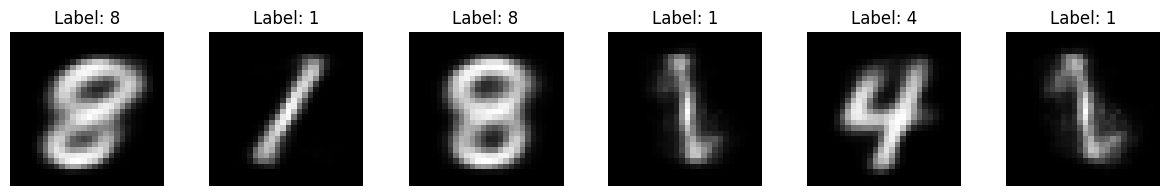


##################################################
CVAE-MLP Epoch [7/20], Loss: 135.48490784505208


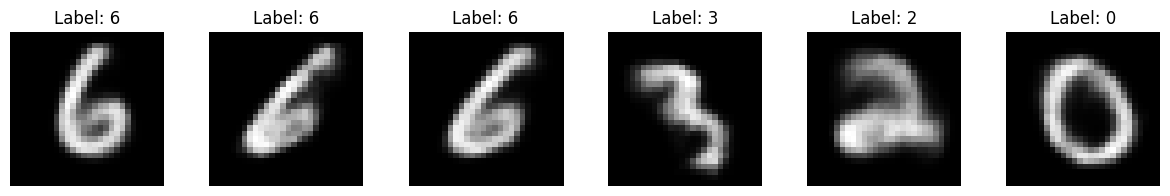


##################################################
CVAE-MLP Epoch [8/20], Loss: 134.69166438802083


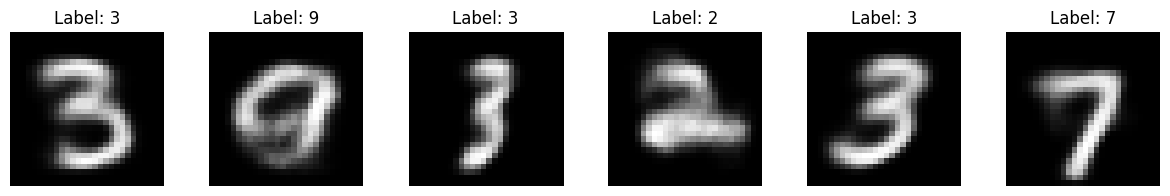


##################################################
CVAE-MLP Epoch [9/20], Loss: 134.00708248697916


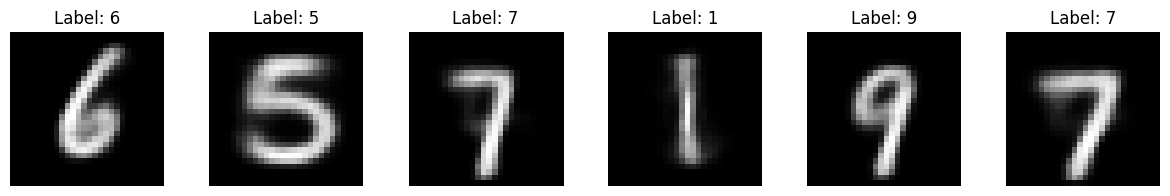


##################################################
CVAE-MLP Epoch [10/20], Loss: 133.5290942545573


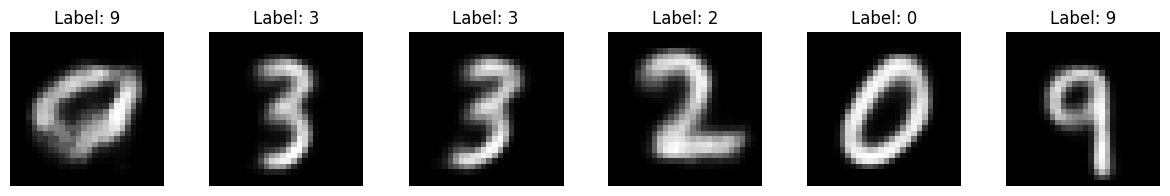


##################################################
CVAE-MLP Epoch [11/20], Loss: 132.9804815592448


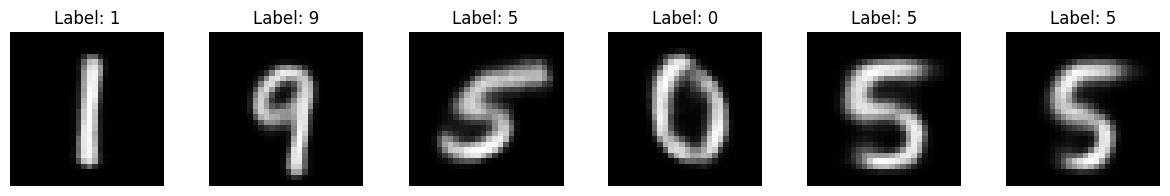


##################################################
CVAE-MLP Epoch [12/20], Loss: 132.59940564778645


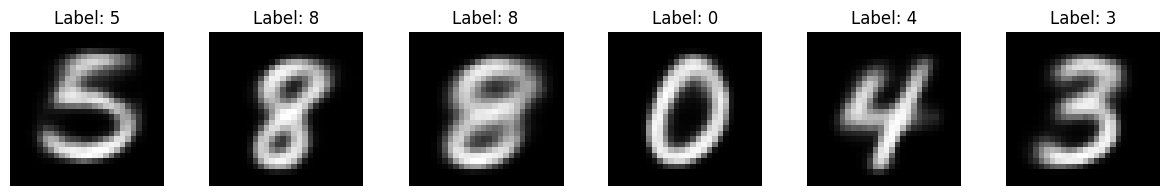


##################################################
CVAE-MLP Epoch [13/20], Loss: 132.20745380859375


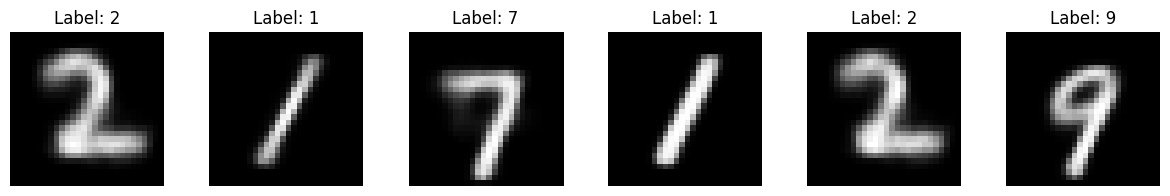


##################################################
CVAE-MLP Epoch [14/20], Loss: 131.90109993489583


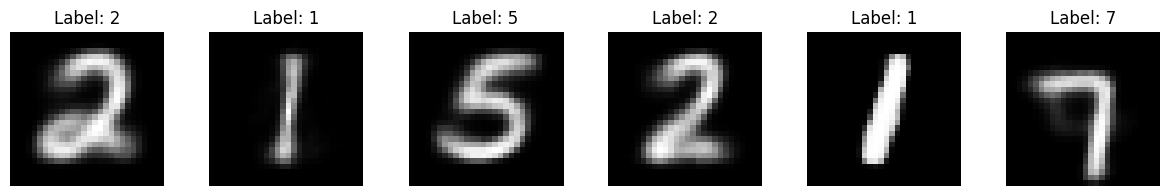


##################################################
CVAE-MLP Epoch [15/20], Loss: 131.67370579427083


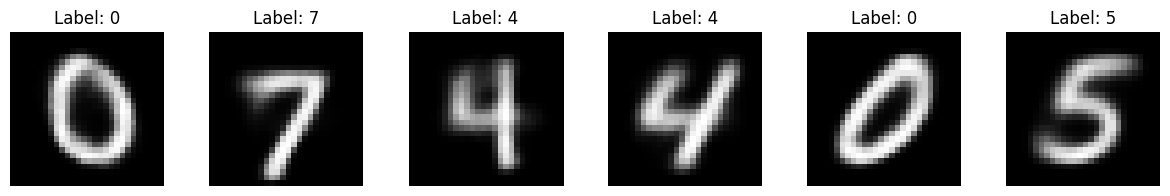


##################################################
CVAE-MLP Epoch [16/20], Loss: 131.37756298828126


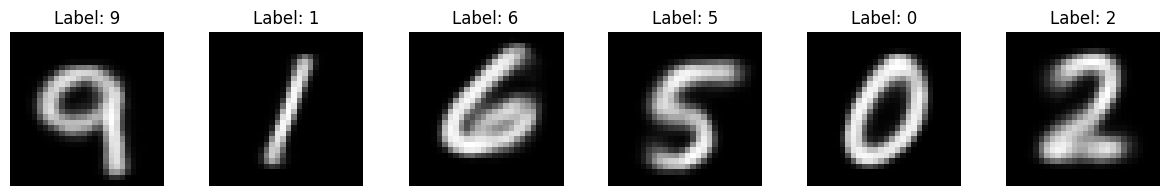


##################################################
CVAE-MLP Epoch [17/20], Loss: 131.22285152994792


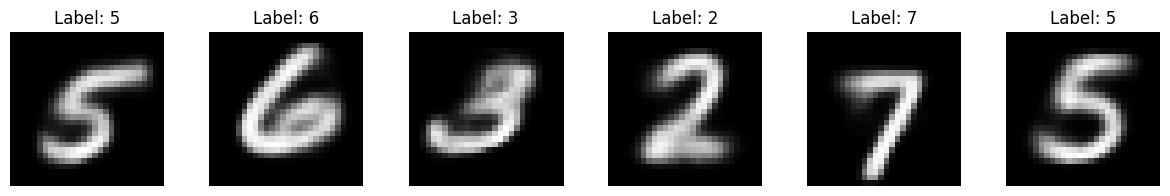


##################################################
CVAE-MLP Epoch [18/20], Loss: 130.9964942220052


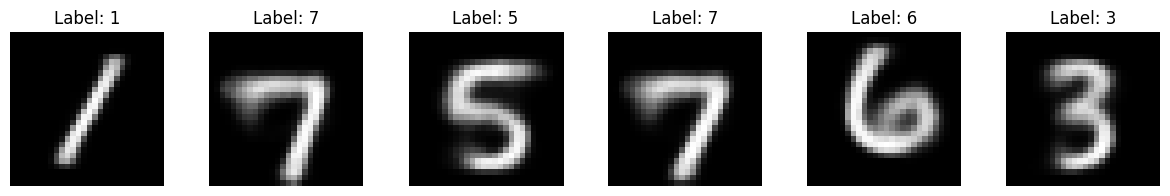


##################################################
CVAE-MLP Epoch [19/20], Loss: 130.7890993326823


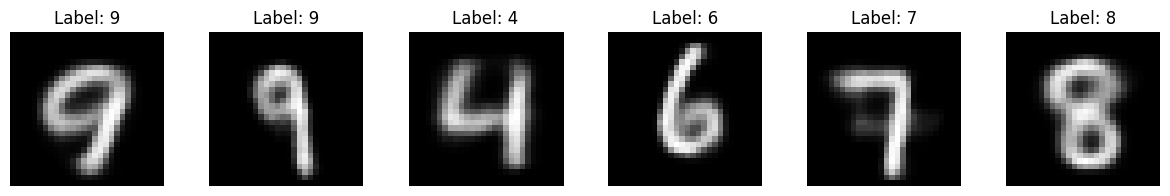


##################################################
CVAE-MLP Epoch [20/20], Loss: 130.63811090494792


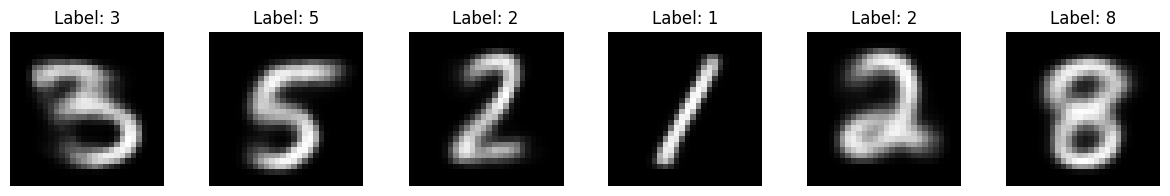

Best model saved as 'best_cvae_mlp_model.pth'


In [14]:
# Train CVAE-MLP
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 2
cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [27]:
import seaborn as sns

# Function to visualize latent space distribution
def visualize_latent_space(model, data_loader, num_samples=1000, title="Latent Space Distribution"):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch_idx, (data, labels_batch) in enumerate(data_loader):
            if len(latent_vectors) >= num_samples:
                break

            # Move input data to GPU
            data = data
            labels_batch = labels_batch
#             print('label batch',labels_batch)


            # Forward pass to get latent vectors
            if isinstance(model, VAE_MLP):
                recon, mu, logvar = model(data)
                latent_vectors.append(mu)
            elif isinstance(model, CVAE_MLP):
                labels_one_hot = F.one_hot(labels_batch, num_classes=10).float()
                
#                 print('label',labels_one_hot)
                recon, mu, logvar, class_logits = model(data, labels_one_hot)
#                 print('class digit',class_logits)
                latent_vectors.append(mu)

            labels.append(labels_batch)

    latent_vectors = torch.cat(latent_vectors, dim=0).cpu().numpy()
    labels = torch.cat(labels, dim=0).cpu().numpy()

    # Plotting
#     sns.scatterplot(x=latent_vectors[:, 0], y=latent_vectors[:, 1], hue=labels, palette="tab10", s=8)
    sns.scatterplot(x=latent_vectors[:, 0], y=latent_vectors[:, 1], hue=labels, palette="tab10")


    plt.title(title)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.legend(title="Class")
    plt.show()
 


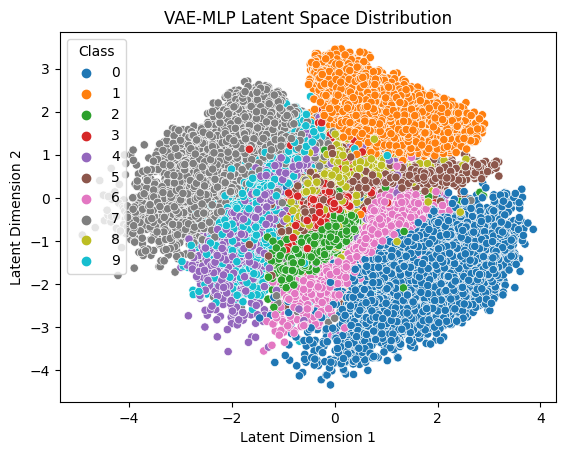

In [28]:
# Load the final trained model for VAE
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 2
vae_mlp_final = VAE_MLP(input_dim, hidden_dim, latent_dim)
vae_mlp_final.load_state_dict(torch.load('best_vae_mlp_model.pth'))

# Visualize latent space distribution for VAE-MLP
visualize_latent_space(vae_mlp_final, train_loader, title="VAE-MLP Latent Space Distribution")


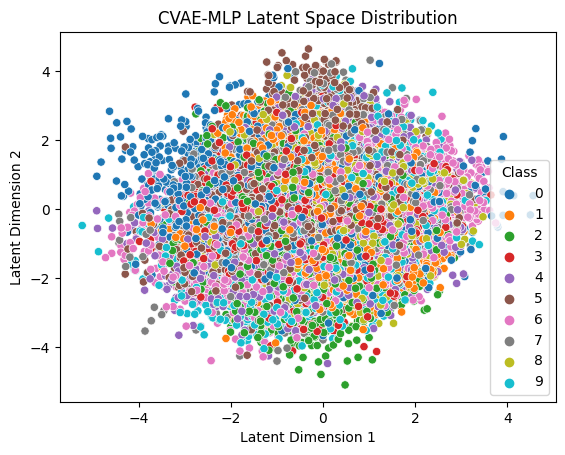

In [29]:
# Load the final trained model for CVAE
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 2
cvae_mlp_final = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes=10)
cvae_mlp_final.load_state_dict(torch.load('best_cvae_mlp_model.pth'))

# Visualize latent space distribution for CVAE-MLP
visualize_latent_space(cvae_mlp_final, train_loader, title="CVAE-MLP Latent Space Distribution")